# Complexité des algorithmes récursifs

Jusqu'à présent, nous avons étudié la complexité des boucles. Ces complexités permettent de déterminer la complexité de la plupart des algorithmes itératifs. Pour les algorithmes récursifs, l'étude de la complexité est souvent plus complexe. Nous allons voir dans ce cours un théorème central pour l'étude de ces complexités : le **master theorem**. Nous illustrerons ses résultats en testant les différents cas de figure

## Outils de test

Cette partie met en place quelques outils pour tracer des courbes, et évaluer les performances de programmes.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import time
import numpy as np
import math
import random

In [2]:
def plot_array(array, log = False):
    if log:
        plt.semilogy(array)
    else:
        plt.plot(array)
    plt.show()

def plot_fun(f, input):
    vals = np.array([f(i) for i in input])
    plot_array(vals)
    return vals

def perf(f, input, trials=10):
    res = []
    for i in input:
        t = time.time()
        for j in range(trials):
            f(i)
        res.append((time.time() - t)/trials)
    return np.array(res)
    

## Formulation de la complexité d'un algorithme récursif

La complexité d'un algorithme récursif peut être décomposée en deux termes :
  * la complexité dûe aux appels récursifs ;
  * la complexité dûe aux calcul séparant les données pour réaliser les appels, ou reconstruisant le résultat après les appels.
  
### Exemple : recherche dichotomique

In [3]:
def dicho_search_internal(tab, start, end, value):
    if end - start == 1:
        return tab[start] == value
    else:
        mid = int((start + end)/2)
        if tab[mid] > value:
            return dicho_search_internal(tab, start, mid, value)
        else:
            return dicho_search_internal(tab, mid, end, value)

def dicho_search(tab,value):
    return dicho_search_internal(tab,0,len(tab),value)

In [4]:
t = np.arange(0,100,10)
t

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [5]:
dicho_search(t,62), dicho_search(t,50)

(False, True)

Dans cet algorithme, le coût de la séparation des données pour réaliser l'appel est constant : il s'agit simplement de calculer la valeur stockée dans la variable `mid`. Ensuite le résultat est renvoyé immédiatement, donc le coût de reconstruction du résultat est nul. Le coût total de ces opération est donc $\Theta(1)$. Pour les appels récursifs, les paramètres importants sont que le problème initial est divisé en **1** problème de taille **1/2**. Étant donné ces éléments, si $T(n)$ est la complexité pour une entrée de taille $n$, nous avons alors la formule suivante :

$$T(n) = T\left(\frac{n}{2}\right) + \Theta(1)$$

Notez ici que le $\Theta(1)$ est important. Sans lui, nous aurions $T(n) = T(\frac{n}{2}) = T(\frac{n}{4}) = \ldots = T(1) = 1$, or cet algorithme n'a certainement pas un temps d'éxécution indépendant de la taille des données.

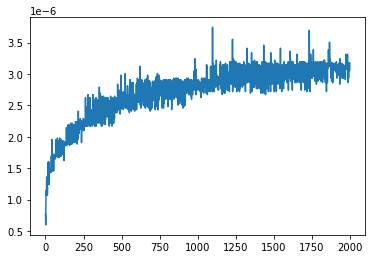

In [6]:
def dicho_test(arglist):
    return dicho_search(*arglist)

dicho_inputs = [[sorted([random.randint(1,100) for i in range(k)]), random.randint(1,100)] for k in range(1,2000)]

dicho_perfs = perf(dicho_test, dicho_inputs)
plot_array(dicho_perfs)

### Exemple : maximum

Voici maintenant un algorithme qui consiste à calculer le maximum d'un ensemble de valeurs stockées dans un tableau. Plutôt que de calculer le maximum en parcourant linéairement le tableau, on le calcule à la manière d'un tournoi : mettons que nous connaissons le maximum de la première moitié du tableau et celui de la seconde moitié du tableau, il ne reste qu'à jouer la finale pour déterminer lequel des deux est le maximum de l'ensemble. Récursivement, pour chaque moitié, on redivise en deux et on fait la demi-finale, et ainsi de suite.

In [7]:
def splitmax_internal(tab, start, end):
    if end - start == 1 :
        return tab[start]
    else:
        mid = int((start + end)/2)
        m1 = splitmax_internal(tab, start, mid)
        m2 = splitmax_internal(tab, mid, end)
        if m1 < m2 :
            return m2
        else:
            return m1
        
def splitmax(tab):
    return splitmax_internal(tab, 0, len(tab))

In [8]:
splitmax([1, 3, 2, 5, 8, 7, 6])

8

Dans cet algorithme, le coût de la séparation des données est constant, il consiste à calculer la valeur de `mid`. Le coût de reconstruction du résultat consiste à comparer deux nombres et à renvoyer le plus grand des deux. Ce coût est également constant. Pour les appels récursifs, le problème est découpé en deux problèmes de taille $\frac{1}{2}$. Nous avons donc la formule
$$
  T(n) = 2T\left(\frac{n}{2}\right) + \Theta(1).
$$

Le fait que le problème soit divisé en deux sous-problème pourrait donner l'intuition que la complexité de cet algorithme est logarithmique. En réalité un simple argument de bon sens permet de contredire cette idée : $\log{n}$ croît moins vite que $n$, autrement dit, considérer que la complexité est logarithmique revient à dire qu'il est possible de calculer le maximum d'un tableau de $n$ valeurs en moins de $n$ opérations, donc sans avoir à examiner toutes les valeurs.

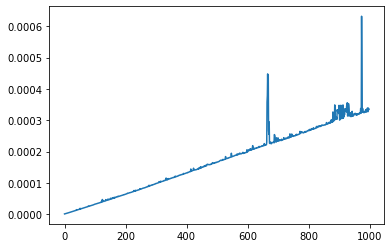

In [9]:
splitmax_inputs = [[random.randint(1,1000) for i in range(k)] for k in range(1,1000)]
splitmax_perfs = perf(splitmax, splitmax_inputs)
plot_array(splitmax_perfs)

La courbe semble indiquer un comportement linéaire.

### Exemple : tri fusion

Le tri fusion est un tri classique surtout en programmation fonctionnelle, car il est efficace en particulier pour des données stockées dans des listes chaînées. Le principe consiste à séparer les données en deux, et à trier les deux moitiés séparément. Ensuite, les deux moitiés triées sont regroupées pour former la liste totale triée. La clé est que regrouper deux listes triés en une seule liste trié peut se faire efficacement : le minimum des deux listes est la tête de l'une des deux listes. Il suffit alors de retirer cette tête, de l'insérer dans la liste résultat, et de poursuivre itérativement l'extraction du minimum des éléments restants.

In [10]:
def fusion_split(t):
    # les deux moitiés
    t1 = []
    t2 = []
    # placer alternativement dans une moitié ou l'autre
    for i,e in enumerate(t):
        if i%2 == 0:
            t1.append(e)
        else:
            t2.append(e)
    return t1,t2

def fusion_merge(t1,t2):
    # le résultat
    t = []
    # les têtes courantes des deus listes à trier
    i1 = 0
    i2 = 0
    # tant qu'on n'a pas épuisé les deux listes
    while i1 < len(t1) or i2 < len(t2):
        if i2 == len(t2) or i1 < len(t1) and t1[i1] < t2[i2]:
            t.append(t1[i1])
            i1 += 1
        else:
            t.append(t2[i2])
            i2 += 1
    return t
    
def fusion_sort(t):
    # un tableau de taille 1 est trié
    if(len(t) > 1):
        # séparation du problème
        t1,t2 = fusion_split(t)
        # tri dés moitiés
        t1s = fusion_sort(t1)
        t2s = fusion_sort(t2)
        # fusion
        return fusion_merge(t1s,t2s)
    return t

In [11]:
t = np.arange(30)
np.random.shuffle(t)
print(t)
ts = fusion_sort(t)
print(ts)

[ 9 25 17 22 28  2 24 18 20 29  7 27  3 23  1 16  6  4 26  8 19 15 13 12
 11 21 14  5 10  0]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


Pour cet algorithme, le coût de la séparation des données est linéaire car on parcourt linéairement la liste à découper. La reconstruction du résultat est également linéaire, car chaque itération de la boucle insère un et un seul élément dans le résultat, jusqu'à épuisement des listes en entrées. Il y aura donc autant d'itération que d'éléments dans ces listes. Au total, toutes ces opérations ont une complexité $\Theta(n)$. En ce qui concerne les appels récursifs, il y en a deux, chacun réalisé sur la moitié des données. nous en déduisons donc la formule :

$$T(n) = 2T\left(\frac{n}{2}\right) + \Theta(n)$$

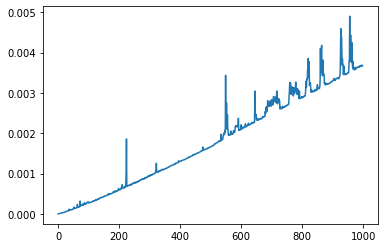

In [12]:
fusion_inputs = [[random.randint(0,1000) for i in range(k)] for k in range(1,1000)]
fusion_perfs = perf(fusion_sort, fusion_inputs)
plot_array(fusion_perfs)

La courbe est presque linéaire, avec un léger infléchissement. En réalité si on divise par une fonction linéaire la courbe obtenue est

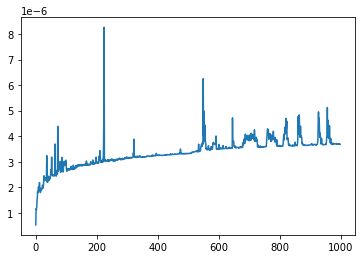

In [13]:
plot_array(fusion_perfs / np.arange(1,1000))

Il semble donc qu'il y ait un logarithme supplémentaire.

### Forme générale des formules recherchées

De manière générale, nous recherons à formuler la complexité de nos algorithmes récursifs sous la forme :

$$T(n) = aT\left(\frac{n}{b}\right) + f(n)$$

  * $a$ est le nombre d'appels récursifs
  * $b$ est le ratio de division du problème
  * $f(n)$ représente le coût des calculs réalisés pour séparer les problèmes etreconstruire le résultat

### Exercice : formuler les complexités des programmes suivants :



In [14]:
def exo1(n):
    if n <= 1:
        return 1
    k = 0 ;
    for i in range(n):
        for j in range(i):
            k = k+1
    k = k + exo1(int(n/3))
    k = k + exo1(int(n/3))
    k = k + exo1(int(n/3))
    return k
            

In [15]:
def exo2(n):
    if n <= 1:
        return 1
    k = 0 ;
    for i in range(25):
        k = k + exo2(int(n/5))
    for i in range(n):
        for j in range(n):
            k = k+1
    return k

## Master Theorem

### Principe

Pour déterminer la complexité de telles formules, il est nécessaire de déterminer ce qui coûte le plus cher entre les calculs réalisés à chaque appel, modélisés par la fonction $f$, et les appels récursifs. Lorsque les calculs réalisés en dehors des appels sont très coûteux, c'est leur complexité qui prend le pas et domine la complexité totale. Lorsqu'au contraire ils ne coûtent rien, c'est la complexité des appels récursifs qui domine. Enfin lorsque les deux sont du même ordre, la complexité devra prendre en compte l'ensemble.

Pour une formule de la forme :

$$ T(n) = aT\left(\frac{n}{b}\right) + f(n)$$

il convient de calculer tout d'abord $\log_b(a)$. La complexité des calculs liés aux appels récursifs est alors donnée par $n^{\log_b(a)}$.

### Cas où les appels récursifs dominent

Le coût des appels récursifs domine si

$$ f(n) = O(n^c)\mbox{, avec }c < \log_b(a).$$

Notez bien que le $O$ est une borne supérieure. Si $f(n)$ est parfois de classe plus faible, la condition tient toujours. Dans ce cas, la complexité liée aux calculs extérieurs aux appels récursifs est négligeable, et c'est la complexité des appels récursifs qui domine. Nous avons alors

$$T(n) = \Theta(n^{\log_b(a)})$$

### Cas où les calculs extérieurs aux appels dominent


Le coût des calculs réalisés pour séparer le problème et reconstruire le résultat domine si

$$ f(n) = \Omega(n^c)\mbox{, avec }c > \log_b(a).$$

De même ici, notez que $\Omega$ est une borne inférieure. Dans ce cas, si $f$ décroît suffisamment vite :

$$\exists k < 1, \exists n_0 > 0, \forall n > n_0, af\left(\frac{n}{b}\right) \leq k f(n)$$

Alors la complexité des calculs réalisés lors de l'appel initial domine, et nous avons

$$T(n) = \Theta(f(n))$$.

### Cas où les deux aspects sont du même ordre

Dans le cas où $f(n) = \Theta(n^{\log_b(a)})$, les deux parties interagissent, et la complexité résultante est donnée par

$$T(n) = \Theta\left(n^{\log_b(a)}\log(n)\right)$$.

## Vérification

### Fonctions référence de base

Nous codons ici les fonctions de base des classes de complexité : polynomes et logarithme.

In [16]:
def pow_fun(p, f = lambda x: x):
    return lambda n : pow(f(n),p)

Une fonction linéaire :

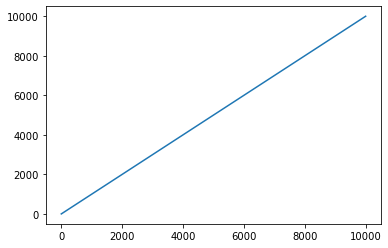

In [17]:
lin_fun = pow_fun(1)
lin_p = plot_fun(lin_fun, range(10000))

Une fonction quadratique :

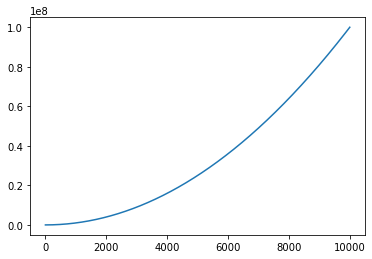

In [18]:
quad_fun = pow_fun(2)
quad_p = plot_fun(quad_fun, range(10000))

Une fonction logarithmique :

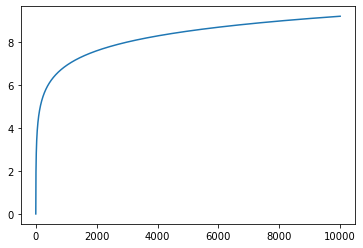

In [19]:
log_p = plot_fun(math.log, range(1,10000))

### Retour sur les exemples

D'après le master theorem, pour la recherche dichotomique, nous avons 

$$T(n) = T(\frac{n}{2}) + \Theta(1)$$

donc $a = 1$, $b = 2$, $f(n) = \Theta(1)$. Nous avons $\log_b(a) = \log_2(1) = 0$ et $f(n) = \Theta(1) = \Theta(n^0)$. Nous sommes donc dans le troisième cas du Master Theorem où les appels récursifs et les calculs extérieurs sont du même ordre. La complexité est donc $T(n) = n^0\log_2(n) = \log_2(n)$.

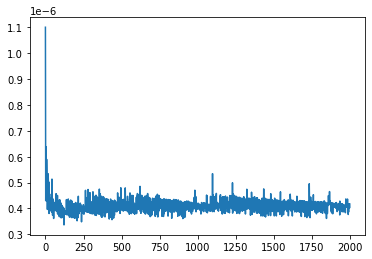

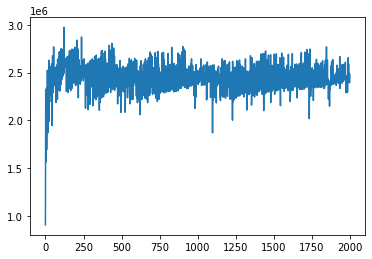

In [20]:
plot_array(dicho_perfs / log_p[1:2000])
plot_array(log_p[1:2000] / dicho_perfs)

Les deux courbes semblent bien indiquer que $T(n) = \Theta(\log_2{n})$

Pour la recherche de maximum, nous avons 

$$T(n) = 2T(\frac{n}{2}) + \Theta(1)$$

donc $a = 2$, $b = 2$ et $f(n) = \Theta(1)$. Dans ce cas $\log_b(a) = \log_2(2) = 1$ et $f(n) = \Theta(n^0)$. Nous sommes dans le premier cas du Master Theorem où le coût des appels récursifs est prépondérant, et nous avons donc $T(n) = \Theta(n)$.

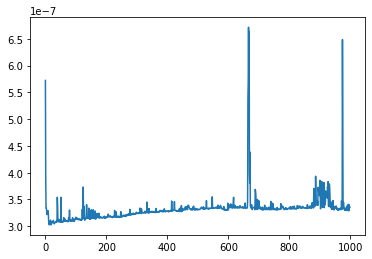

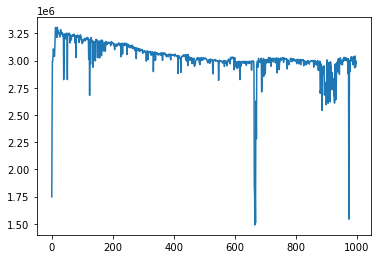

In [21]:
plot_array(splitmax_perfs / lin_p[1:1000])
plot_array(lin_p[1:1000] / splitmax_perfs)

Les courbes semblent confirmer le résultat.

Pour le tri fusion enfin, nous avons 

$$T(n) = 2T(\frac{n}{2}) + \Theta(n)$$

donc $a = 2$, $b = 2$ et $f(n) = \Theta(n)$. Dans ce cas, $\log_b(a) = \log_2(2) = 1$ et $f(n) = \Theta(n)$. Nous sommes donc dans le second cas du Master Théorem, et obtenons la complexité $T(n) = n\log_2(n)$.

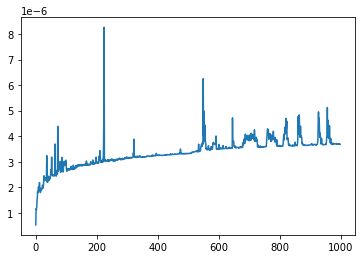

In [22]:
plot_array(fusion_perfs / lin_p[1:1000])

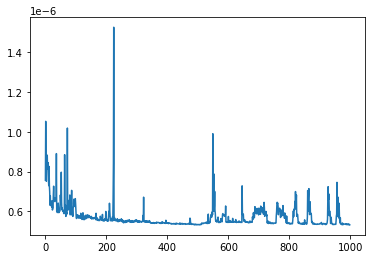

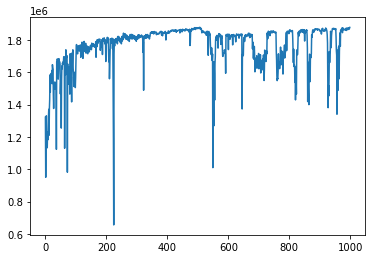

In [23]:
plot_array(fusion_perfs / (lin_p[1:1000] * log_p[1:1000]))
plot_array((lin_p[1:1000] * log_p[1:1000]) / fusion_perfs)

De nouveau le résultat semble validé.

Pour tester et valider le Master Theorem sur un programme synthétique, vous pouvez utiliser la fonction suivante :

In [24]:
def generic_mt_test_internal(a,b,f,n):
    if n == 1:
        return f(1)
    s = f(n)
    sub = n / b
    isub = int(sub)
    fsub = sub - isub
    for i in range(a):
        if random.uniform(0,1) < fsub:
            s += generic_mt_test_internal(a,b,f,isub + 1)
        else:
            s += generic_mt_test_internal(a,b,f,isub)
    return s

def generic_mt_test(a,b,f):
    return lambda n : generic_mt_test_internal(a,b,f,n)   

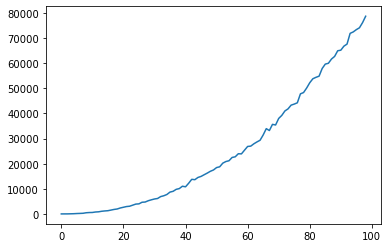

In [25]:
gmt_inputs = range(1,100)
gmt_perf = plot_fun(generic_mt_test(4,2,lambda x : x*x), gmt_inputs)

Théoriquement, en appliquant le Master Theorem pour $a = 4$, $b = 2$ et $f(n) = n^2$ on obtient $T(n) = Theta(n^2\log_2{n})$. Vérifions :

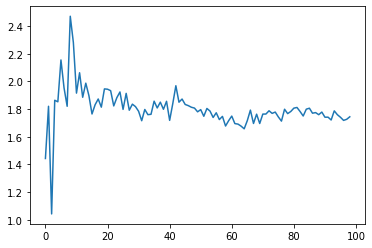

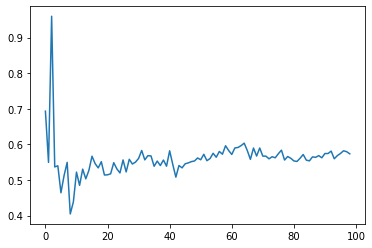

In [26]:
plot_array(gmt_perf / (lin_p[1:100]*lin_p[1:100]*log_p[1:100]))
plot_array((lin_p[1:100]*lin_p[1:100]*log_p[1:100]) / gmt_perf )